# Experimentation: Digitally Reconstructed Radiography (DRR)
---

[Gopalakrishnan and Golland, 2022](https://doi.org/10.1007/978-3-031-23179-7_1) presented a method for solving inverse problems in intraoperative imaging using fast auto-differentiable digitally reconstructed radiographs. In this notebook, we apply the method described in their work to solve a similar problem in our analysis.

`DiffDRR` is implemented as a custom PyTorch module.

In [1]:
# Import libraries
import sys
sys.path.append("..")

from monai.config import print_config
from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

print_config()

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about ins

## Application for Abdominal CT Scans

In [2]:
# Get transforms
transform = get_transforms()

# Get datasets
train_ds, val_ds = get_datasets(root_dir="../data", collection="HCC-TACE-Seg", transform=transform, download_len=5, val_frac=0.2)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets and dataloaders
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))

2024-03-24 11:27:08,206 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-03-24 11:27:08,206 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-03-24 11:27:08,206 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-03-24 11:27:08,697 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-03-24 11:27:08,697 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-03-24 11:27:08,697 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-03-24 11:27:08,963 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [3]:
# Check the first batch
batch = next(iter(train_loader))

torch.Size([5, 512, 512, 64])


In [4]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

# Print useful information about the image and segmentation
print(image.shape, seg.shape)
print(image.dtype, seg.dtype)
print(type(image), type(seg))

# Print the metadata of the image
print(image.meta)

torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 5, 64, 64, 64])
torch.float32 torch.float32
<class 'monai.data.meta_tensor.MetaTensor'> <class 'monai.data.meta_tensor.MetaTensor'>
{original_affine: tensor([[[ -0.7031,   0.0000,   0.0000, 176.4000],
         [  0.0000,  -0.7031,   0.0000, 180.0000],
         [  0.0000,   0.0000,  -2.5000, -65.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]], dtype=torch.float64), 'spacing': tensor([[0.7031, 0.7031, 2.5000]], dtype=torch.float64), 'filename_or_obj': ['..\\data\\HCC-TACE-Seg\\HCC_017\\300\\image'], 'lastImagePositionPatient': tensor([[-176.4000, -180.0000, -220.0000]], dtype=torch.float64), '00280030': {'vr': ['DS'], 'Value': [tensor([0.7031], dtype=torch.float64), tensor([0.7031], dtype=torch.float64), tensor([2.5000], dtype=torch.float64)]}, spatial_shape: [tensor([512]), tensor([512]), tensor([63])], original_channel_dim: tensor([nan], dtype=torch.float64), '00200032': {'vr': ['DS'], 'Value': [tensor([-176.4000], dtype=torch.fl

In [5]:
# Get the CT volume and spacing from the image metadata
volume, spacing = image, image.meta["spacing"]

# Calculate the isocenter
iso = torch.tensor(volume.shape[2:]) * spacing / 2

# Convert the spacing to a list
spacing = spacing.tolist()[0]

# Convert the volume to a numpy array
volume = volume.squeeze().numpy()

# Flatten the isocenter tensor
iso = iso.flatten()

# Extract the isocenter coordinates
bx, by, bz = iso[0], iso[1], iso[2]

print(bx, by, bz)
print(volume.shape)

tensor(22.5000, dtype=torch.float64) tensor(22.5000, dtype=torch.float64) tensor(80., dtype=torch.float64)
(64, 64, 64)


In [6]:
drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

In [11]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx, by, bz]], device=device)


In [12]:
img_liver = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

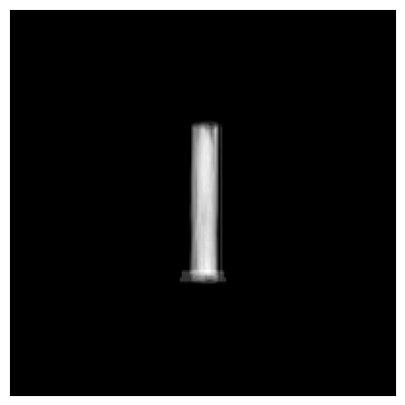

In [13]:
# Plot the DRR
plot_drr(img_liver, ticks=False)
plt.show()